# <center> Movie Review Sentiment Analysis </center>
## <center> Classify the sentiment of sentences from the Rotten Tomatoes dataset </center>

Data link https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data

In [ ]:
# imports
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g6pRAqpB0bGS_S7an-UTGxRrdVWEctuA-ECW1uh870rtqDJ-FR0WzY
Mounted at /content/drive


In [ ]:
train = pd.read_csv('train.tsv.zip',sep = '\t')

In [ ]:
test = pd.read_csv('test.tsv.zip',sep = '\t')

In [ ]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [ ]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [ ]:
class_count = train['Sentiment'].value_counts()
class_count

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

### The sentiment labels are:

0 - negative
1 - somewhat negative
2 - neutral
3 - somewhat positive
4 - positive

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Number of reviews ')

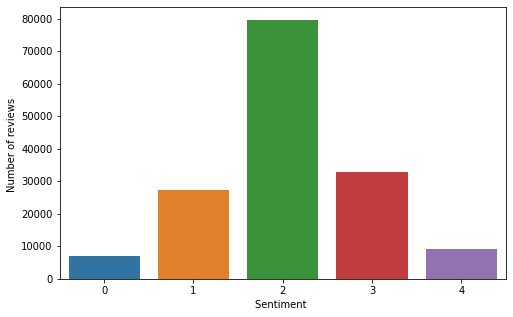

In [ ]:
x = np.array(class_count.index)
y = np.array(class_count.values)
plt.figure(figsize=(8,5))
sns.barplot(x,y)
plt.xlabel('Sentiment ')
plt.ylabel('Number of reviews ')


In [ ]:
print('Number of sentences in training set:',len(train['SentenceId'].unique()))
print('Number of sentences in test set:',len(test['SentenceId'].unique()))
print('Average words per sentence in train:',train.groupby('SentenceId')['Phrase'].count().mean())
print('Average words per sentence in test:',test.groupby('SentenceId')['Phrase'].count().mean())

Number of sentences in training set: 8529
Number of sentences in test set: 3310
Average words per sentence in train: 18.297572986282095
Average words per sentence in test: 20.027794561933536


### Using Word Clouds to see the higher fequency words from each sentiment

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        # stopwords=stopwords,
        max_words=100,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

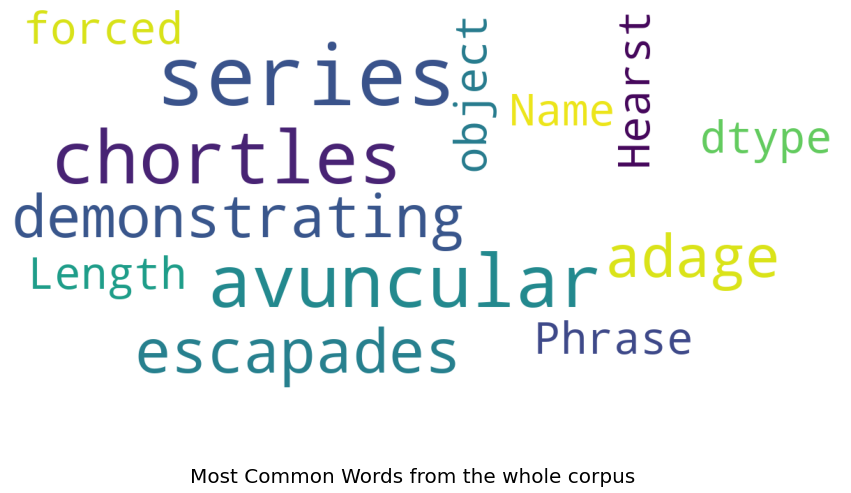

In [ ]:
show_wordcloud(train['Phrase'],'Most Common Words from the whole corpus')

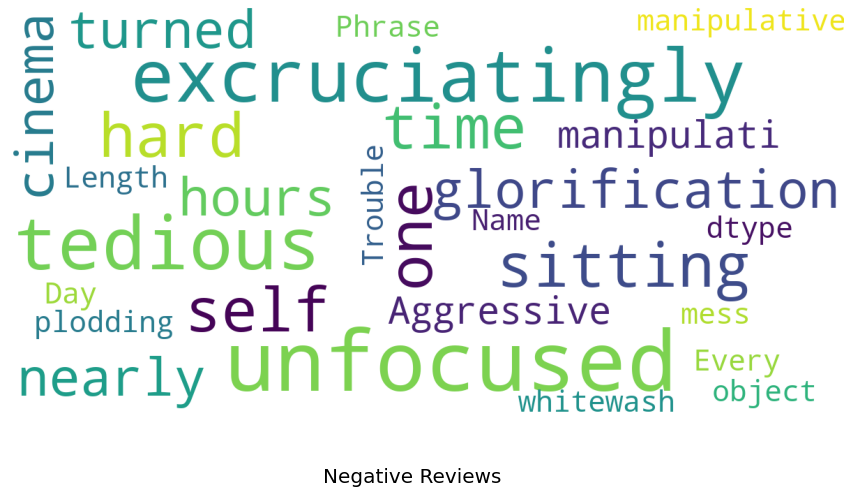

In [ ]:

show_wordcloud(train[train['Sentiment'] == 0]['Phrase'],'Negative Reviews')

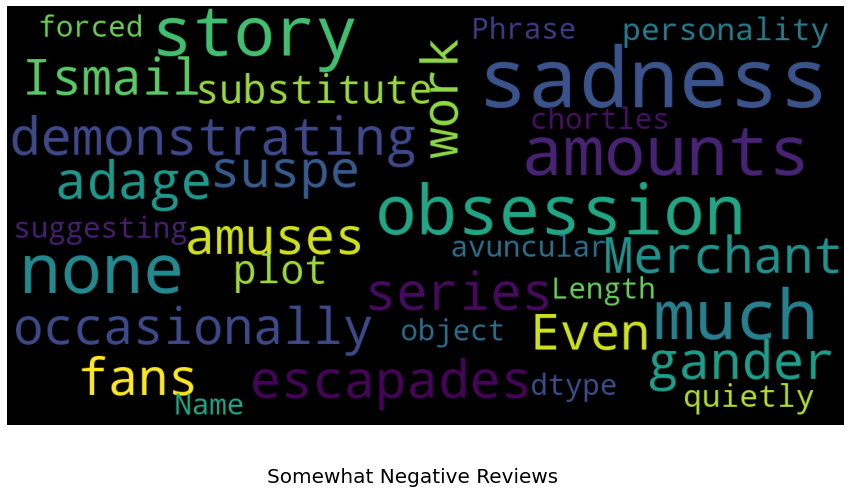

In [ ]:

show_wordcloud(train[train['Sentiment'] == 1]['Phrase'],'Somewhat Negative Reviews')


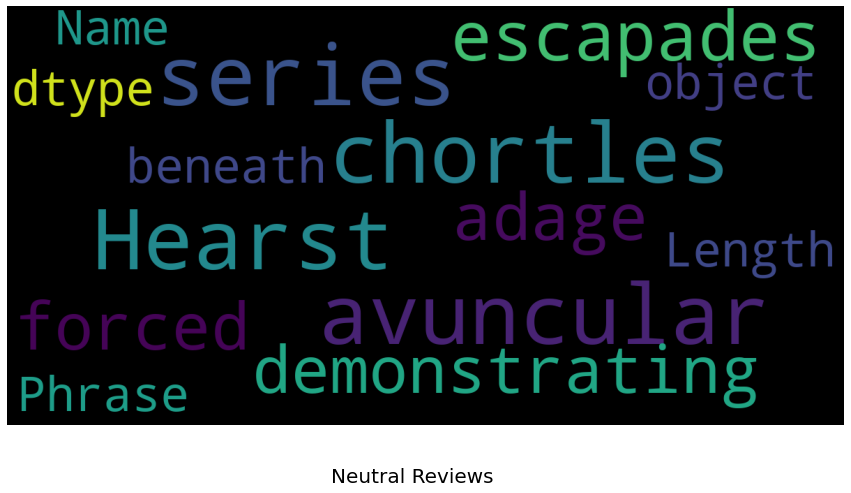

In [ ]:
show_wordcloud(train[train['Sentiment'] == 2]['Phrase'],'Neutral Reviews')

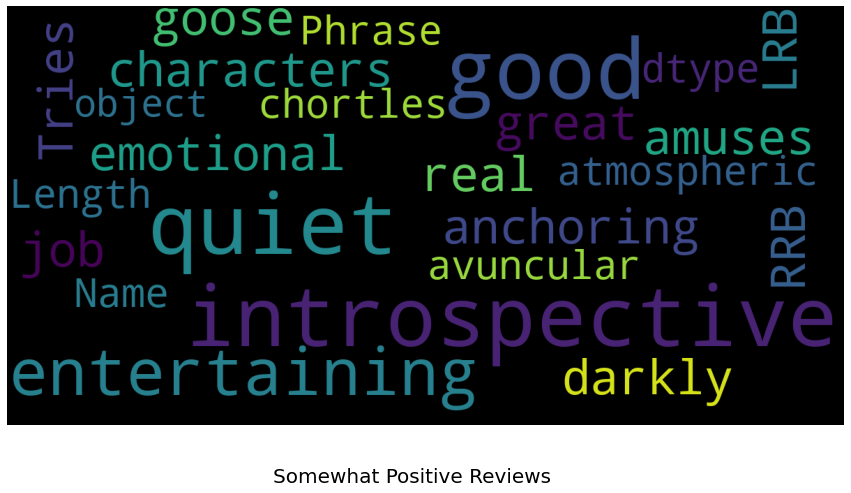

In [ ]:

show_wordcloud(train[train['Sentiment'] == 3]['Phrase'],'Somewhat Positive Reviews')

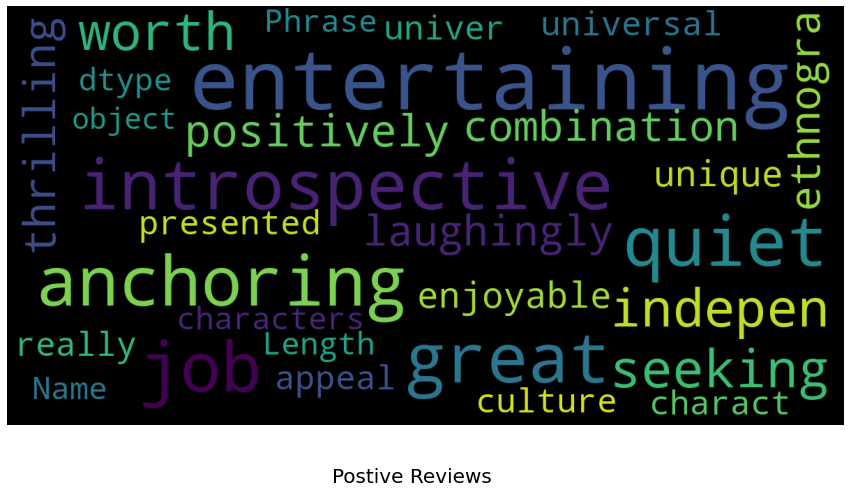

In [ ]:

show_wordcloud(train[train['Sentiment'] == 4]['Phrase'],'Postive Reviews')

### Word Embeddings

In [ ]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
import tensorflow as tf
from tensorflow.keras.models import Sequential

In [ ]:
def data_cleaning(lines):
  import nltk
  clean_lines = []
  for line in lines:
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    new_words = tokenizer.tokenize(line.lower())
    clean_lines.append(" ".join(new_words))
  print("no of clean lines = ", len(clean_lines))
  return clean_lines

In [ ]:
def get_embedding_model(voc_size,dim,input_length):
  model=Sequential()
  model.add(Embedding(voc_size,dim,input_length=input_length))
  model.compile('adam','mse')
  return model

In [ ]:
def test_embeddings_2Dmatrix(clean_lines,model,input_length,voc_size=20000):
  onehot_repr=[one_hot(line,voc_size) for line in clean_lines]
  embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=input_length)
  embedding_matrix = model.predict(embedded_docs)
  print("Embedding matrix shape is ",embedding_matrix.shape )
  embedding_matrix_2D = np.mean(embedding_matrix,axis=2)
  print("2D matrix shape is ",embedding_matrix_2D.shape )
  return embedding_matrix_2D,model,input_length

In [ ]:
def train_embeddings_2Dmatrix(clean_lines,voc_size=20000, dim=2):
  tf.random.set_seed(7)
  onehot_repr=[one_hot(line,voc_size) for line in clean_lines]
  print("Size of one hot encoded input is",len(onehot_repr), len(onehot_repr[0]))
  embedded_docs=pad_sequences(onehot_repr,padding='pre')
  print("Size after padding is =",embedded_docs.shape)
  input_length = len(embedded_docs[0])
  model = get_embedding_model(voc_size,dim,input_length)
  embedding_matrix = model.predict(embedded_docs)
  print("Embedding matrix shape is ",embedding_matrix.shape )
  embedding_matrix_2D = np.mean(embedding_matrix,axis=2)
  print("2D matrix shape is ",embedding_matrix_2D.shape )
  return embedding_matrix_2D,model,input_length

In [ ]:
def preprocess_data(data,training = True,model = None,input_length=None):
  lines = data['Phrase']
  print("No of records in input =", len(lines))
  clean_lines = data_cleaning(lines)
  if training == True:
    embedding_matrix_2D, model,input_length = train_embeddings_2Dmatrix(clean_lines)
  else:
    embedding_matrix_2D, model,input_length = test_embeddings_2Dmatrix(clean_lines,model,input_length)
  return embedding_matrix_2D ,model,input_length

In [ ]:
train_embedding_matrix_2D,model,input_length = preprocess_data(train[:1000])

No of records in input = 1000
no of clean lines =  1000
Size of one hot encoded input is 1000 35
Size after padding is = (1000, 38)
Embedding matrix shape is  (1000, 38, 2)
2D matrix shape is  (1000, 38)


In [ ]:
test_embedding_matrix_2D,model,input_length = preprocess_data(test[:10],training=False,model=model,input_length = input_length)

No of records in input = 10
no of clean lines =  10
Embedding matrix shape is  (10, 38, 2)
2D matrix shape is  (10, 38)


In [ ]:
X_train = train_embedding_matrix_2D
y_train = train.loc[:(1000-1),'Sentiment']

In [ ]:
from sklearn.model_selection import train_test_split
x_train , x_val, y_train , y_val = train_test_split(X_train,y_train,test_size = 0.2)

<a id='ml'></a>
## <center>  Different Machine Learning Models </center>


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.multiclass import OneVsRestClassifier

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

### Training Logistic Reagression model and an SVM.

In [ ]:
lr = LogisticRegression()
ovr = OneVsRestClassifier(lr)
ovr.fit(x_train,y_train)
print(classification_report( ovr.predict(x_val) , y_val))
print(accuracy_score( ovr.predict(x_val) , y_val ))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       1.00      0.68      0.81       200
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0

    accuracy                           0.68       200
   macro avg       0.20      0.14      0.16       200
weighted avg       1.00      0.68      0.81       200

0.675


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
svm = LinearSVC() # SVC by default has one verses rest approach
svm.fit(x_train,y_train)
print(classification_report( svm.predict(x_val) , y_val))
print(accuracy_score( svm.predict(x_val) , y_val ))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       1.00      0.68      0.81       200
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0

    accuracy                           0.68       200
   macro avg       0.20      0.14      0.16       200
weighted avg       1.00      0.68      0.81       200

0.675


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
estimators = [ ('svm',svm) , ('ovr' , ovr) ]
clf = VotingClassifier(estimators , voting='hard')
clf.fit(x_train,y_train)
print(classification_report( clf.predict(x_val) , y_val))
print(accuracy_score( clf.predict(x_val) , y_val ))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       1.00      0.68      0.81       200
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0

    accuracy                           0.68       200
   macro avg       0.20      0.14      0.16       200
weighted avg       1.00      0.68      0.81       200

0.675


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<a id='N-Grams'></a>
##  <center>1.N-Grams</center>

In [ ]:
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
tokenizer = TweetTokenizer()

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), tokenizer=tokenizer.tokenize)
full_text = list(train['Phrase'].values) + list(test['Phrase'].values)
vectorizer.fit(full_text)
train_vectorized = vectorizer.transform(train['Phrase'])
test_vectorized = vectorizer.transform(test['Phrase'])